In [444]:
import pandas as pd
import numpy as np
import seaborn as sea
from matplotlib import pyplot as plt
import cv2
import random as rd
import zipfile as zp
from sklearn.decomposition import PCA

## Part 1 - Visualizing the Face Images

In [445]:
faces = {}
with zp.ZipFile("face_data.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # If we extracted files from zip, we can use cv2.imread(filename) instead
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

### 1. Visualize randomly selected 16 faces in a 4×4 grid [4 rows and 4 columns].

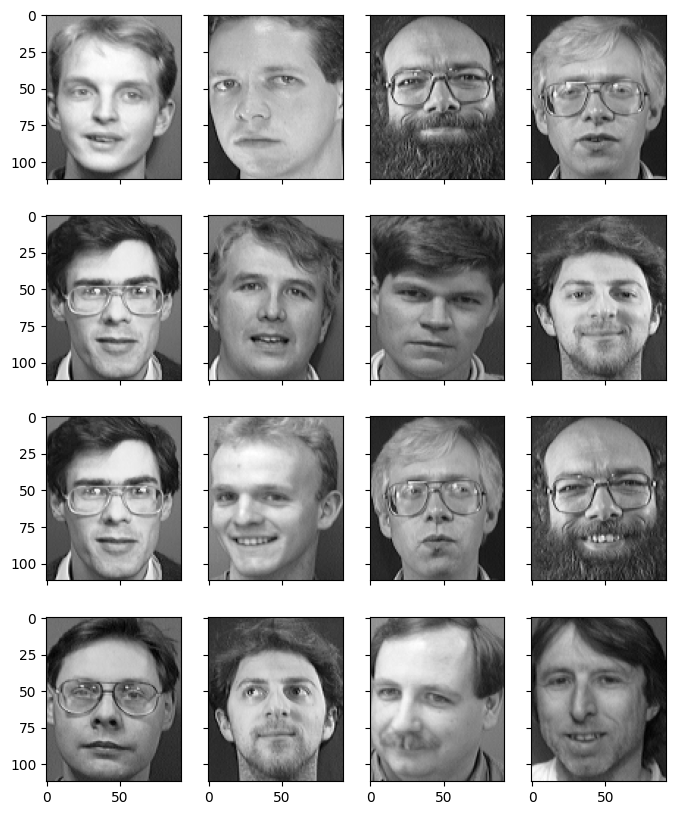

In [446]:
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faces_list = list(faces.values())
face_images = rd.choices(faces_list,k=16) # take 16 images at random
for i in range(16):
    axes[i%4][i//4].imshow(face_images[i], cmap="gray")
plt.show()

### 2. Report the face image size, number of images and number of classes.

In [447]:
faces_size = faces_list[0].shape
print("Face image size:", faces_size)

Face image size: (112, 92)


In [448]:
print("number of images: ",len(faces_list))
classes = set(filename.split("/")[0] for filename in faces.keys())
print("number of classes:", len(classes))

number of images:  400
number of classes: 40


# Part 2 - Train Test split

In [449]:
train_set_matrix=[]
train_set_label=[]
test_set_matrix=[]
test_set_label=[]
for key,val in faces.items():
    # last image of each subject for train set:
    if key.endswith("/10.pgm"):
        test_set_matrix.append(val.flatten())
        test_set_label.append(key.split("/")[0])
    else:
    # first 9 images of each subject for train set:
        train_set_matrix.append(val.flatten())
        train_set_label.append(key.split("/")[0])
train_set_matrix = np.array(train_set_matrix)
test_set_matrix = np.array(test_set_matrix)

In [450]:
print('number of images in train set:',len(train_set_matrix))
print('number of images in test set:',len(test_set_matrix))

number of images in train set: 360
number of images in test set: 40


## Part 3 - Apply PCA using scikit-learn on the Train set

In [451]:
# 1. Apply PCA using scikit-learn on the Train set
pca = PCA().fit(train_set_matrix)

In [452]:
# 2. Take first 20 principal components in the feature space. 
n_components = 20
eigen_faces = pca.components_[:n_components]

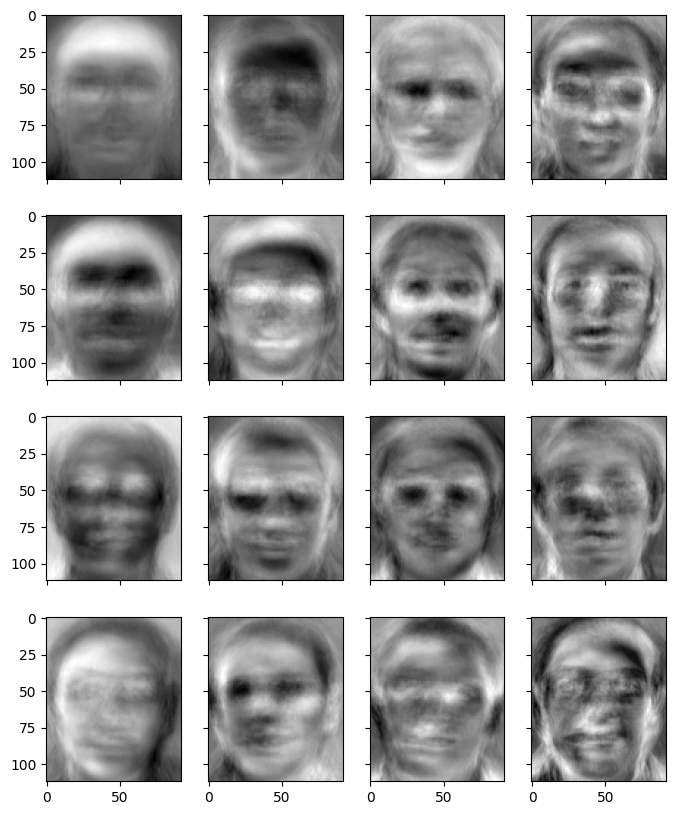

In [453]:
# 3. Visualize the first 16 eigenfaces. reshape the flattened vector to original image shape.
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
    axes[i%4][i//4].imshow(eigen_faces[i].reshape(faces_size), cmap="gray")
plt.show()

# Part 4 - Face Recognition

In [454]:
# Calculate the weights of the training samples using the given formula.
train_sample_weights = []
test_sample_weights = []

train_sample_weights= eigen_faces @ (train_set_matrix - pca.mean_).T

test_sample_weights= eigen_faces @ (test_set_matrix - pca.mean_).T

In [455]:
#take min euclidean dist bet the test image weight and all the training sample weights 
#to predict the class of the test image.
test_image_query = []
best_match=[]
for i in range(len(test_set_matrix)):
    query = test_set_matrix[i].reshape(1,-1)
    test_image_query.append(query)
    query_weight = np.matmul(eigen_faces, (query - pca.mean_).T)
    euclidean_distance = np.linalg.norm(train_sample_weights - query_weight,axis=0)
    best_match.append(np.argmin(euclidean_distance))
print(best_match)

[7, 282, 18, 35, 40, 50, 55, 64, 78, 86, 90, 106, 108, 124, 127, 135, 152, 155, 169, 171, 182, 191, 206, 207, 219, 230, 235, 251, 256, 266, 278, 283, 293, 301, 309, 310, 327, 337, 344, 355]


### Test image query: actual
### Train_set_matrix[best_match[i]] : predicted

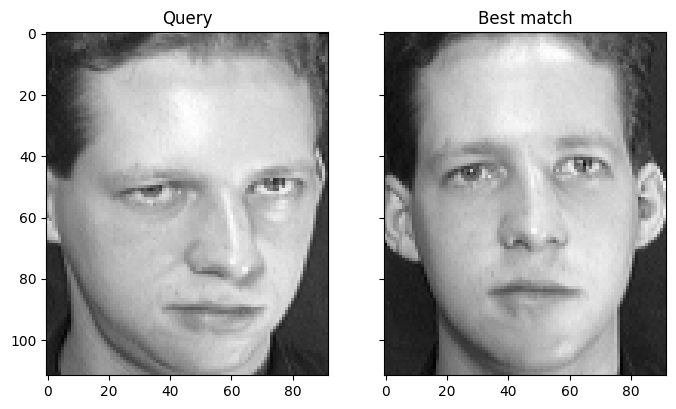

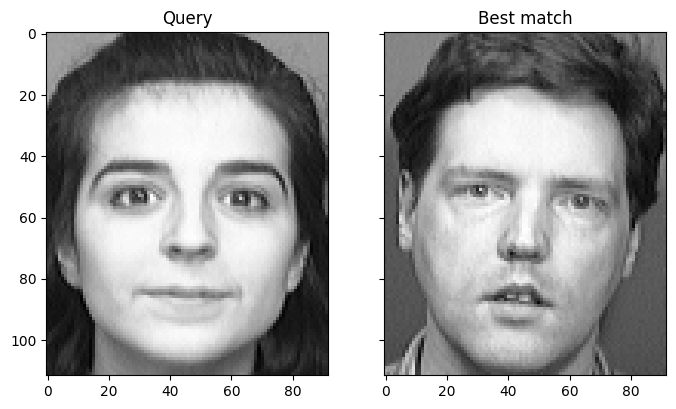

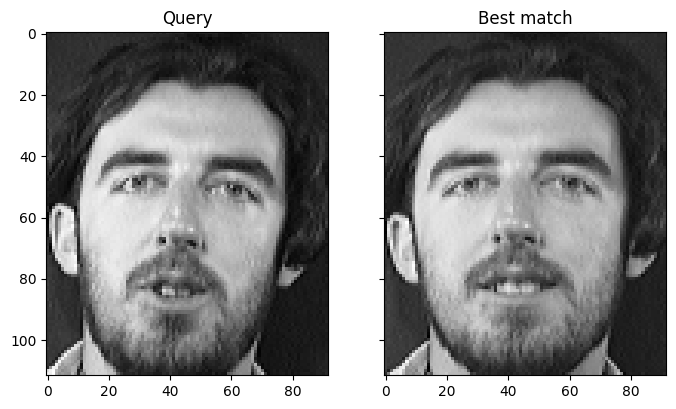

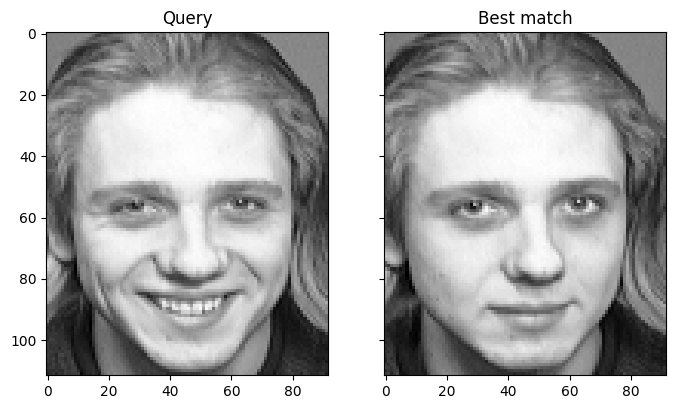

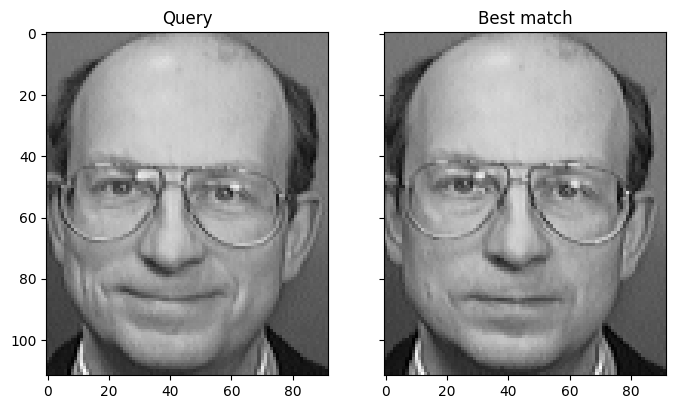

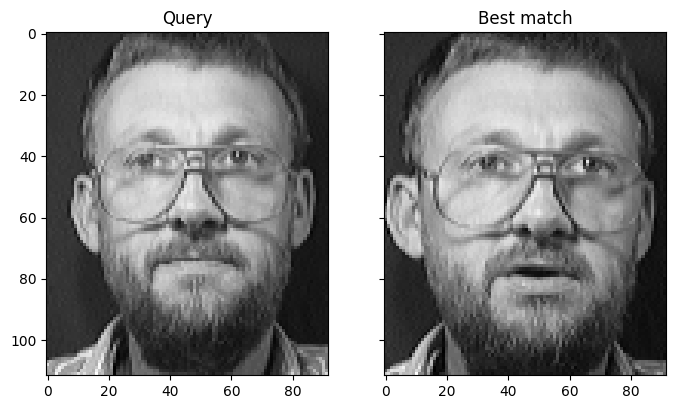

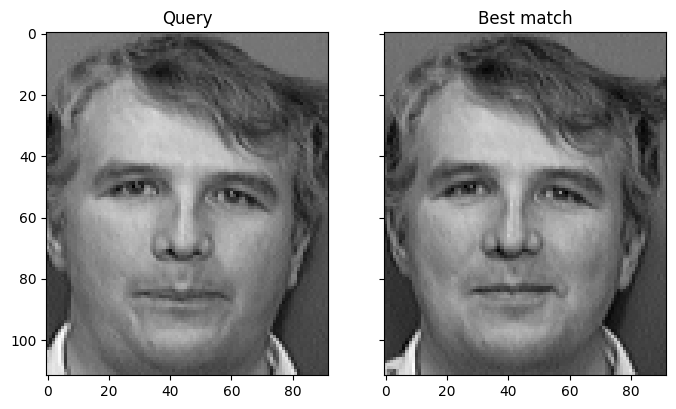

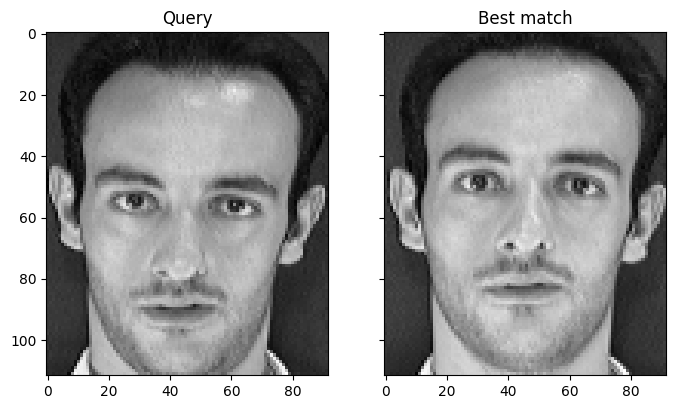

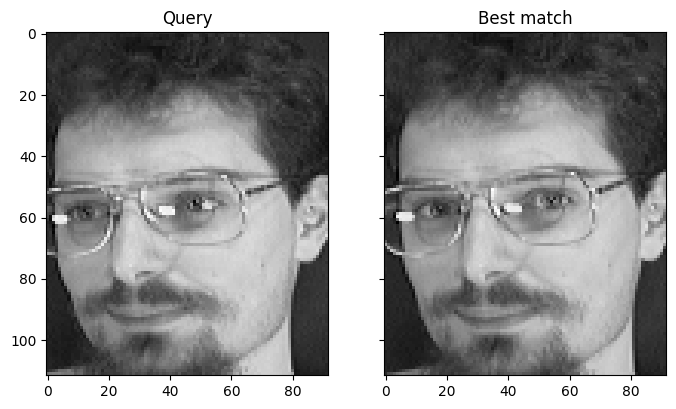

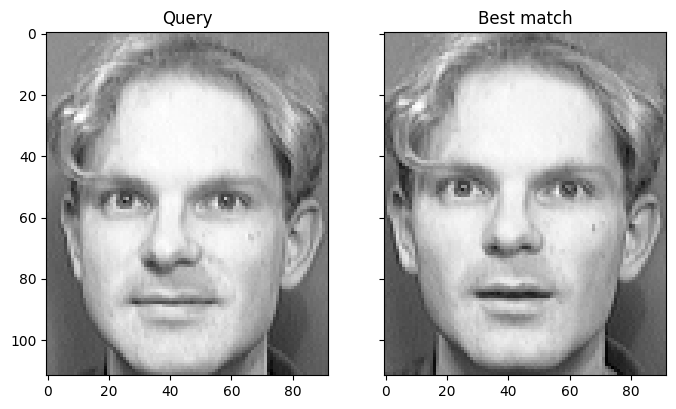

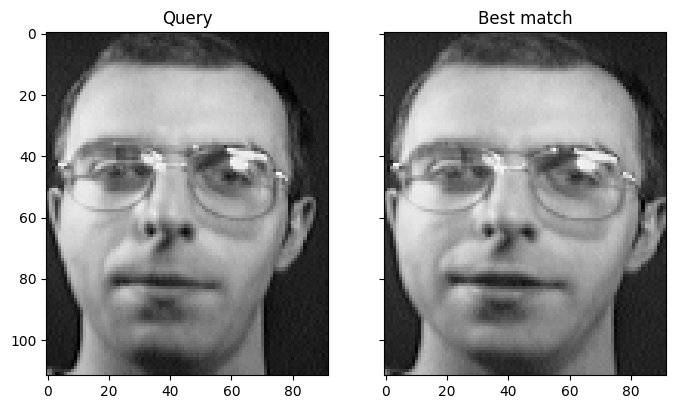

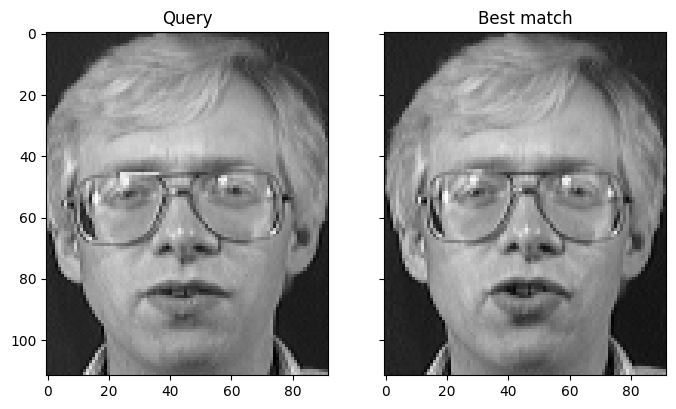

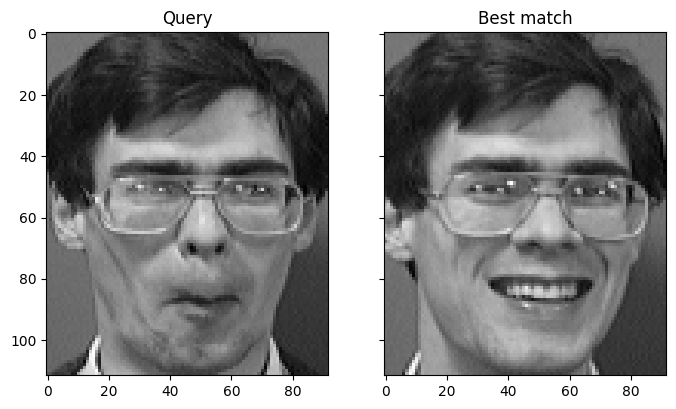

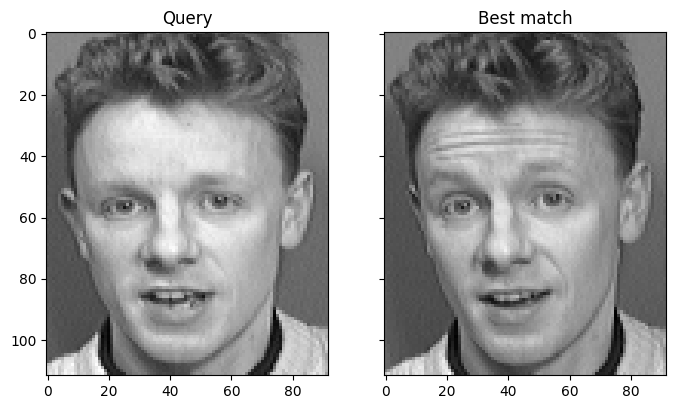

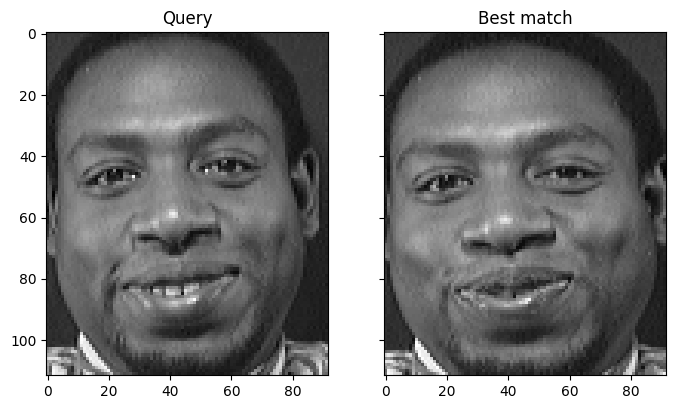

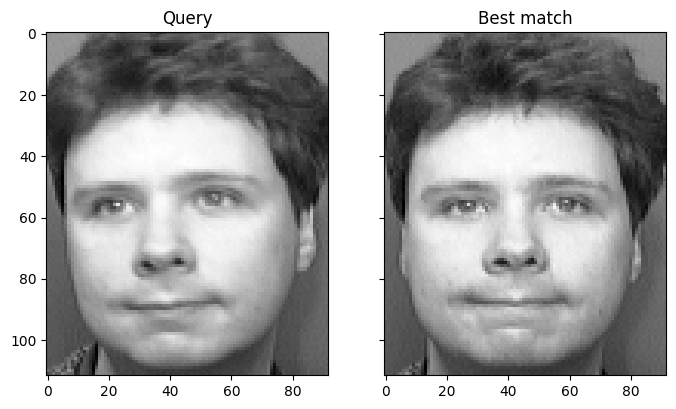

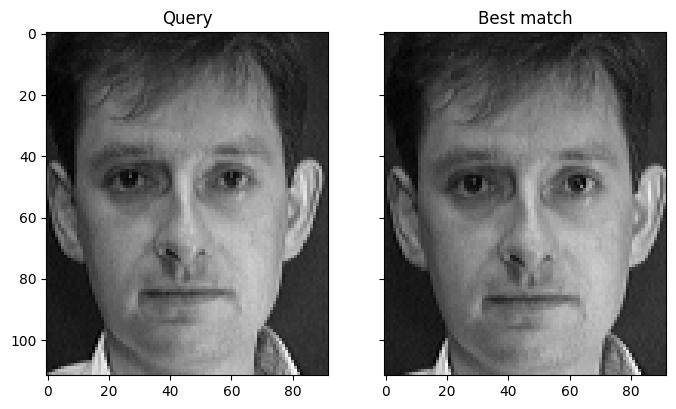

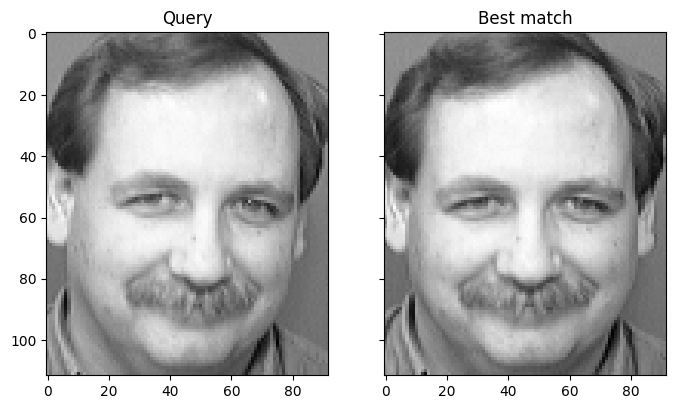

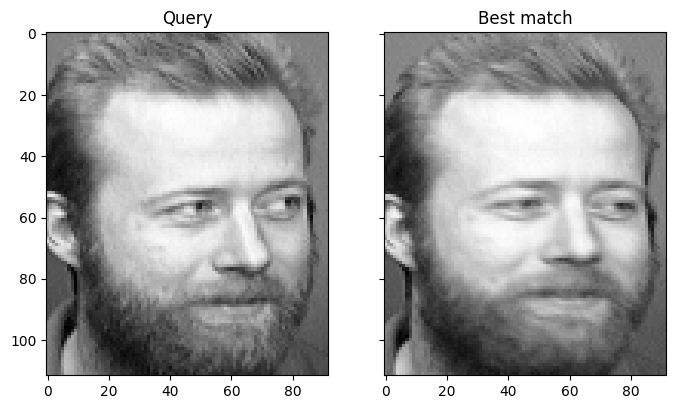

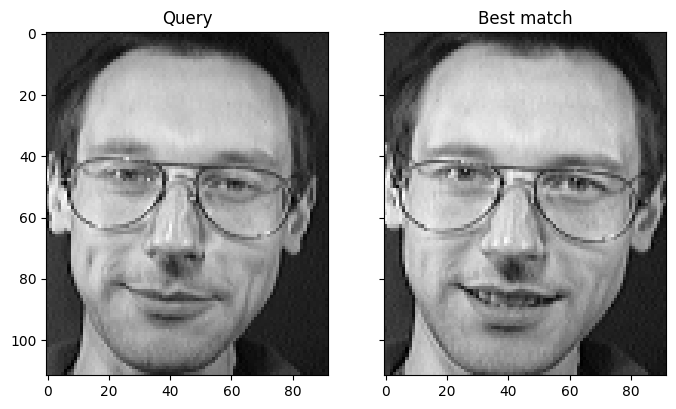

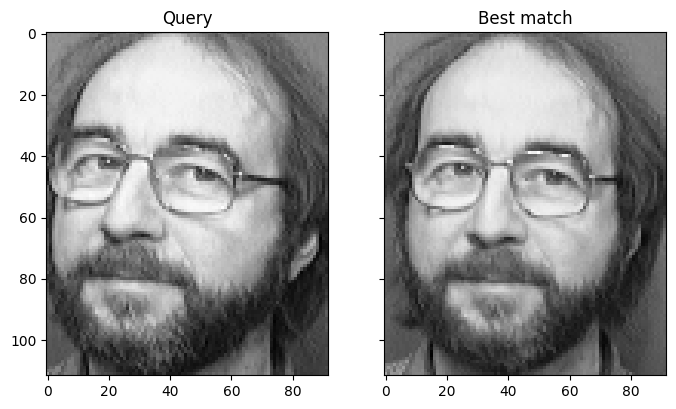

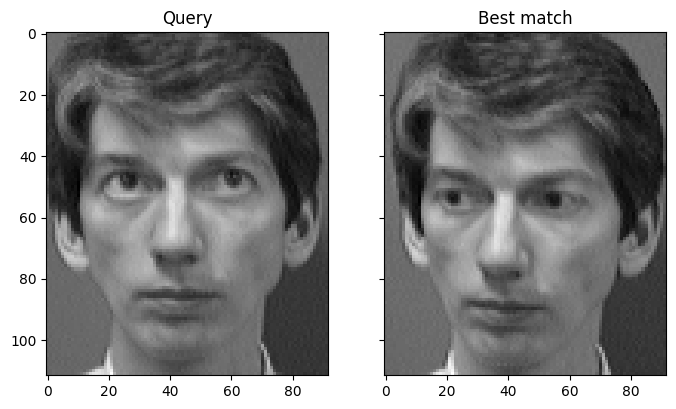

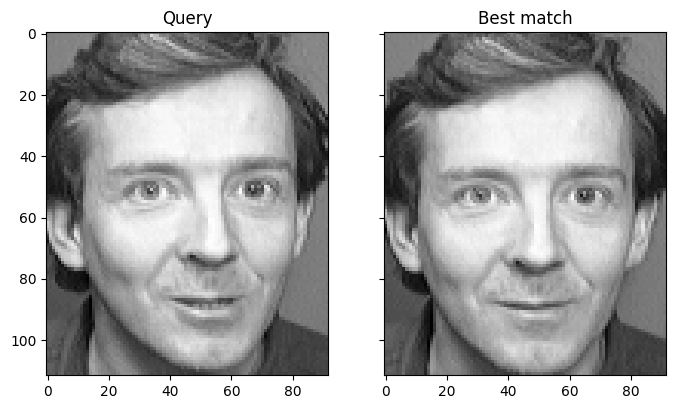

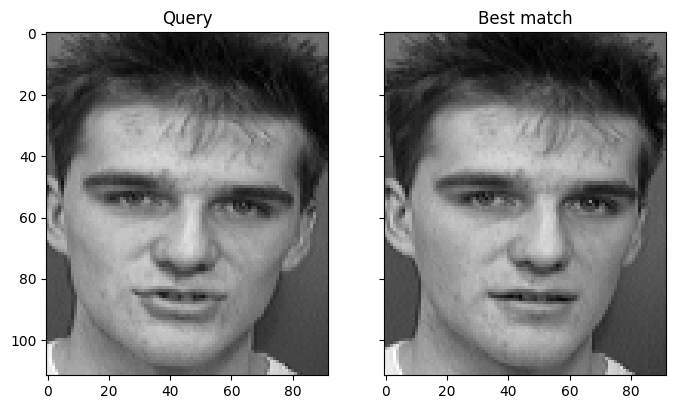

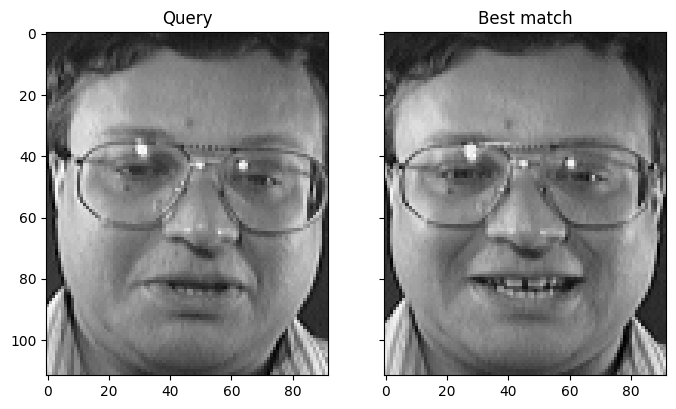

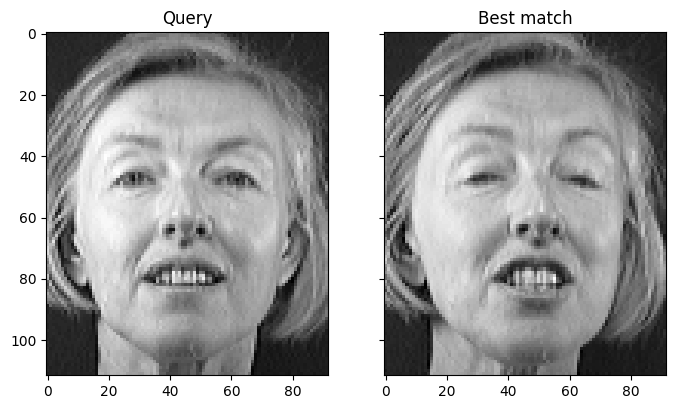

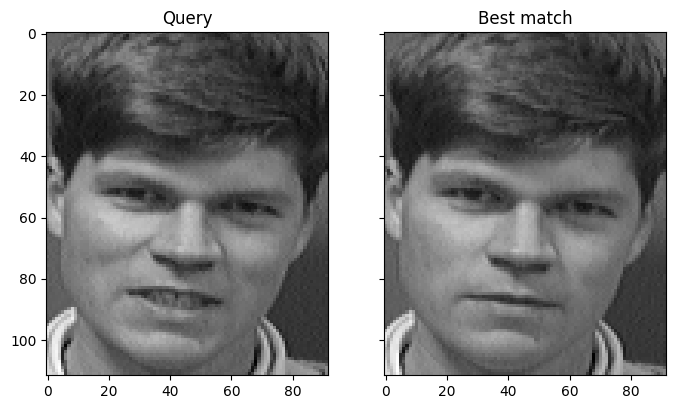

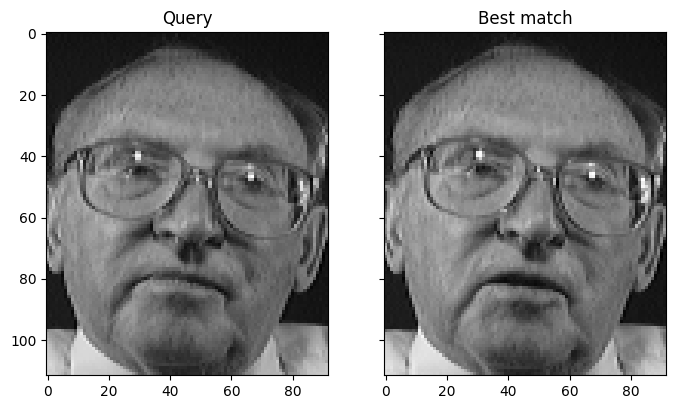

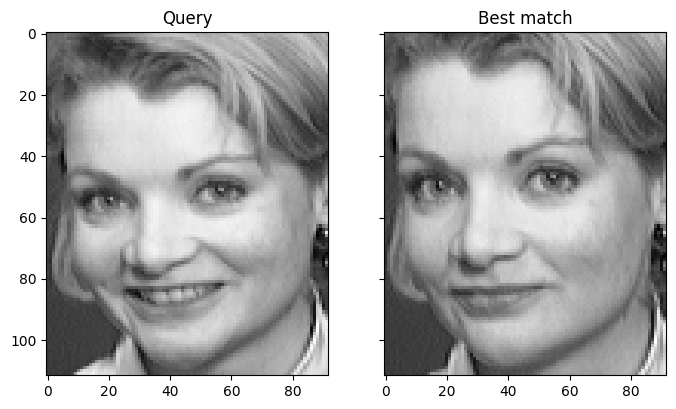

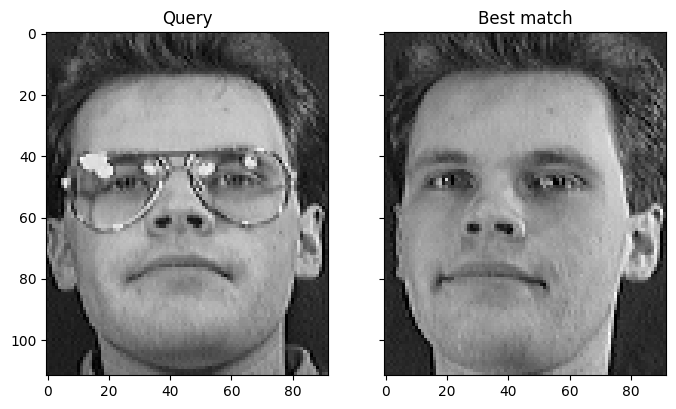

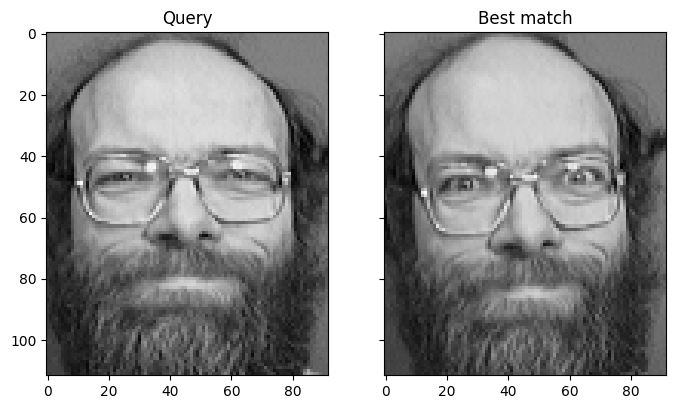

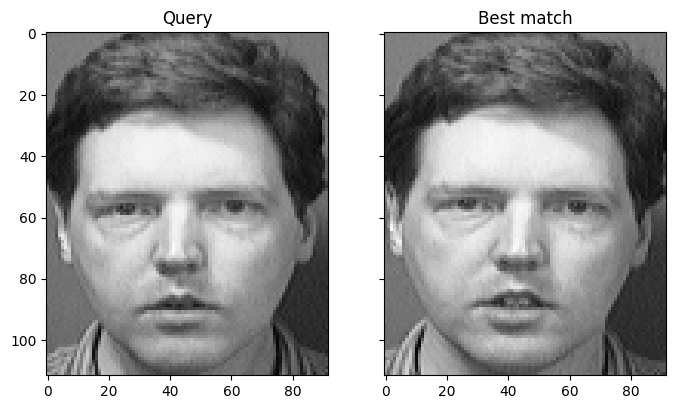

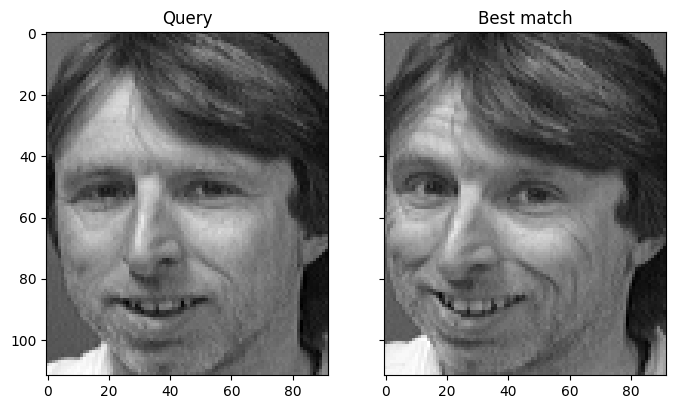

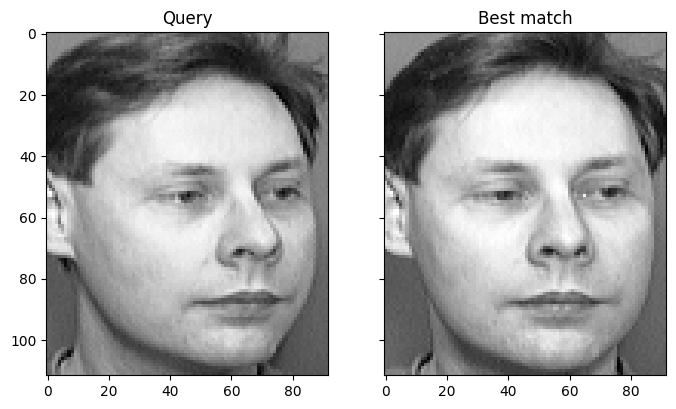

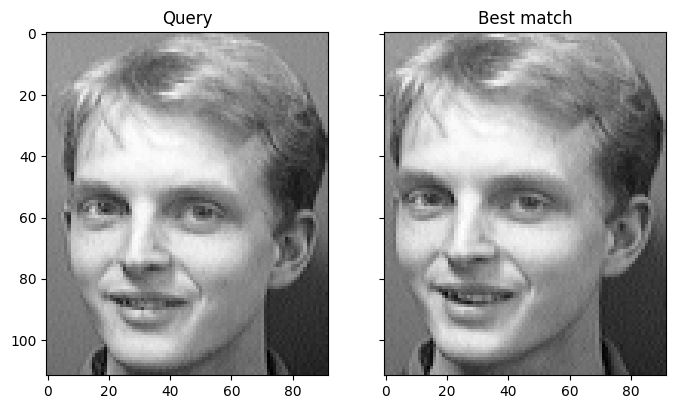

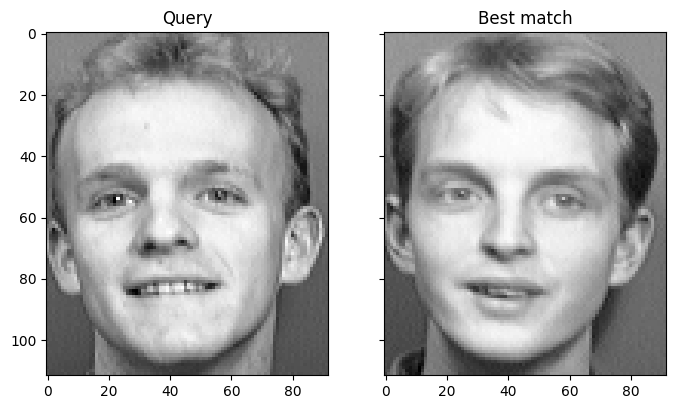

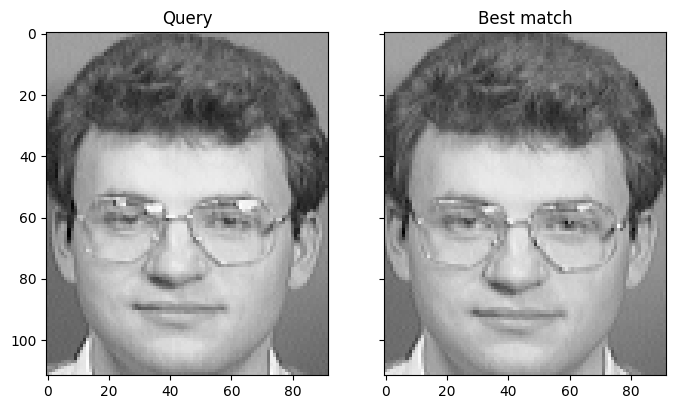

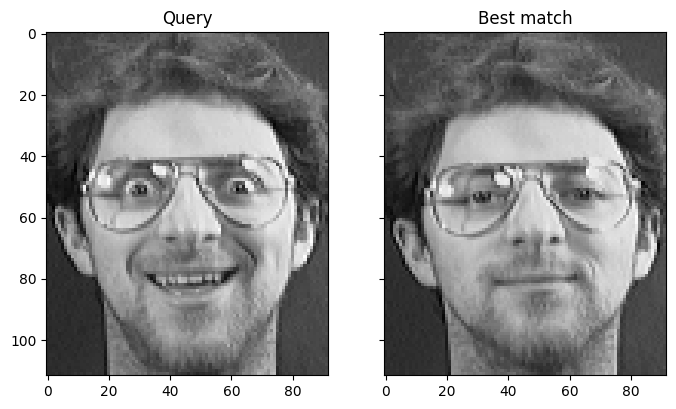

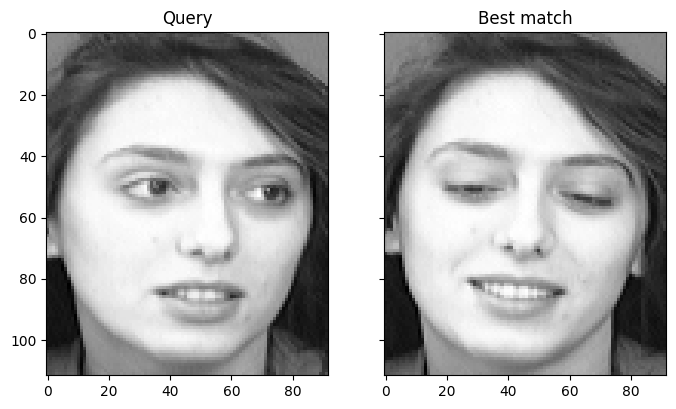

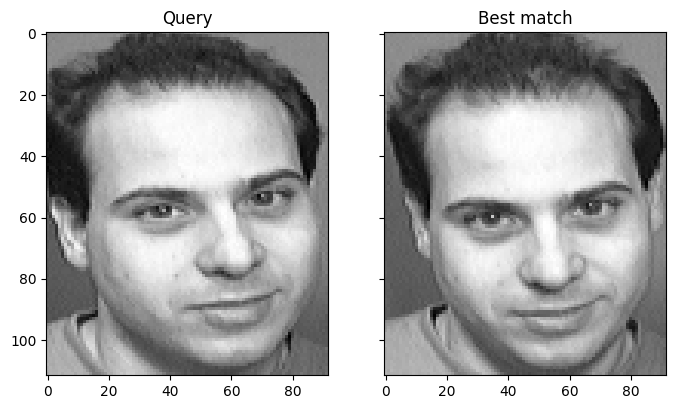

In [456]:
# print("Best match %s with Euclidean distance %f" % (train_set_label[best_match], euclidean_distance[best_match]))
# Visualize
actual_images=[]
predicted_images=[]
for i in range(len(test_set_matrix)):
    fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
    actual = test_image_query[i].reshape(faces_size)
    predicted = train_set_matrix[best_match[i]].reshape(faces_size)
    actual_images.append(actual)
    predicted_images.append(predicted)
    axes[0].imshow(actual, cmap="gray")
    axes[0].set_title("Query")
    axes[1].imshow(predicted, cmap="gray")
    axes[1].set_title("Best match")
    plt.show()



### Accuracy

In [457]:
confusion_matrix = pd.crosstab((np.array(actual_images)).flatten(),(np.array(predicted_images)).flatten())
np.diag(confusion_matrix).sum() / confusion_matrix.to_numpy().sum()

0.03738354037267081

### Total explained variance ratio

[1.78645185e-01 1.27166048e-01 6.86586642e-02 5.63132024e-02
 5.02395014e-02 3.42505004e-02 2.46580881e-02 2.38600047e-02
 1.94878554e-02 1.83499789e-02 1.45933679e-02 1.40734235e-02
 1.11285240e-02 1.06363687e-02 9.75494728e-03 8.98435264e-03
 8.64067769e-03 8.59215661e-03 7.49114026e-03 7.13618841e-03
 6.77522610e-03 6.53752325e-03 6.00103097e-03 5.48407561e-03
 5.29846782e-03 5.12180179e-03 4.77652070e-03 4.75156594e-03
 4.58020106e-03 4.52715131e-03 4.37085636e-03 4.08717406e-03
 3.97530414e-03 3.81964020e-03 3.80299409e-03 3.64856602e-03
 3.49406680e-03 3.39017423e-03 3.14822041e-03 3.09247433e-03
 3.06881348e-03 2.97558479e-03 2.90765943e-03 2.79965537e-03
 2.77156782e-03 2.65789068e-03 2.59150969e-03 2.50923228e-03
 2.46721748e-03 2.42505854e-03 2.34968258e-03 2.27223168e-03
 2.23887022e-03 2.11361296e-03 2.10300898e-03 2.08360801e-03
 2.05760603e-03 2.01638923e-03 2.00025373e-03 1.92293233e-03
 1.87487420e-03 1.82742718e-03 1.80012768e-03 1.77577277e-03
 1.69439196e-03 1.675325

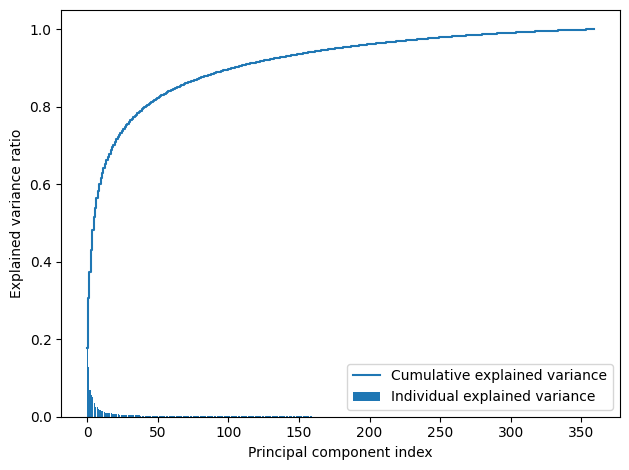

In [458]:
print(pca.explained_variance_ratio_)
exp_var_ratio=pca.explained_variance_ratio_
cumulative_exp = pca.explained_variance_ratio_.cumsum()
plt.bar(range(0,len(exp_var_ratio)),exp_var_ratio, align='center', label='Individual explained variance')
plt.step(range(0,len(cumulative_exp)),cumulative_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Part 5 - Face Recognition

In [459]:
#Repeat Part 4 using only first two principal components instead of 20.
n_components2 = 2
eigen_faces2 = pca.components_[:n_components2]

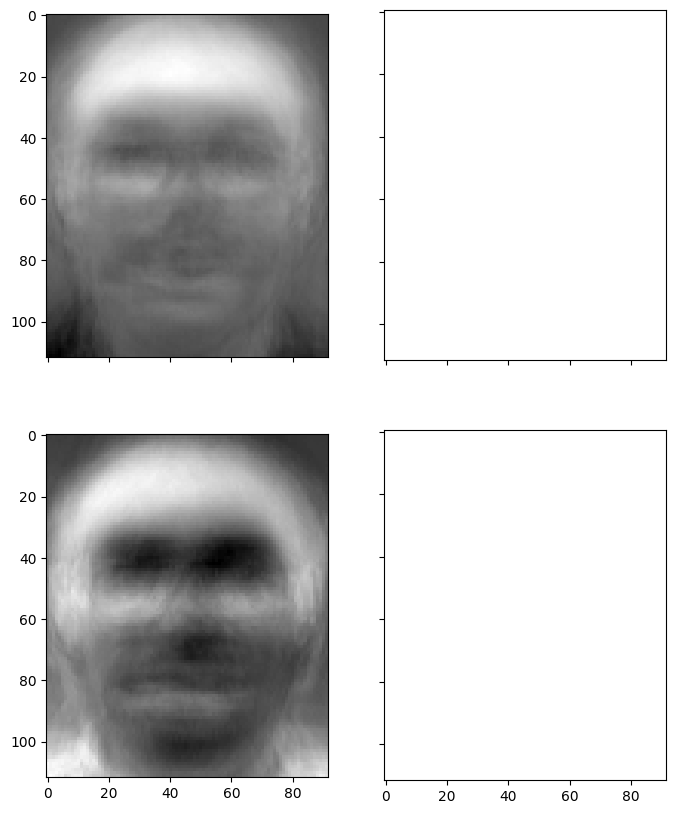

In [460]:
#  Visualize the first two eigenfaces.
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,10))
for i in range(2):
    axes[i%4][i//4].imshow(eigen_faces2[i].reshape(faces_size), cmap="gray")
plt.show()

In [461]:
train_sample_weights2= eigen_faces2 @ (train_set_matrix - pca.mean_).T

test_sample_weights2= eigen_faces2 @ (test_set_matrix - pca.mean_).T

In [462]:
#take min euclidean dist bet the test image weight and all the training sample weights 
#to predict the class of the test image.
test_image_query2 = []
best_match2=[]
for i in range(len(test_set_matrix)):
    query = test_set_matrix[i].reshape(1,-1)
    test_image_query2.append(query)
    query_weight = np.matmul(eigen_faces2, (query - pca.mean_).T)
    euclidean_distance = np.linalg.norm(train_sample_weights2 - query_weight,axis=0)
    best_match2.append(np.argmin(euclidean_distance))
print(best_match2)

[5, 337, 23, 35, 40, 53, 58, 199, 80, 89, 182, 157, 108, 120, 127, 79, 152, 306, 169, 181, 91, 295, 350, 207, 218, 166, 235, 251, 159, 231, 278, 283, 292, 337, 76, 320, 328, 204, 344, 339]


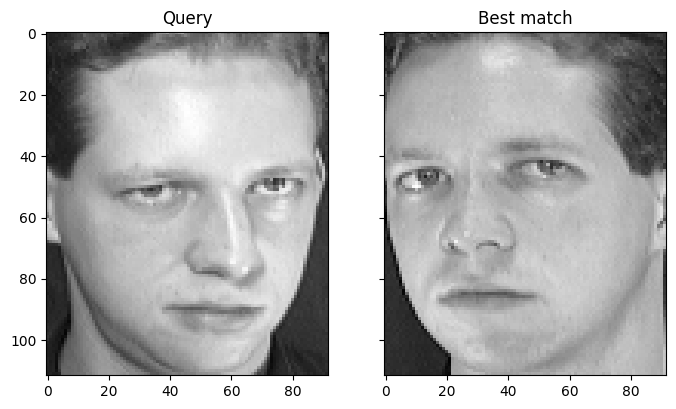

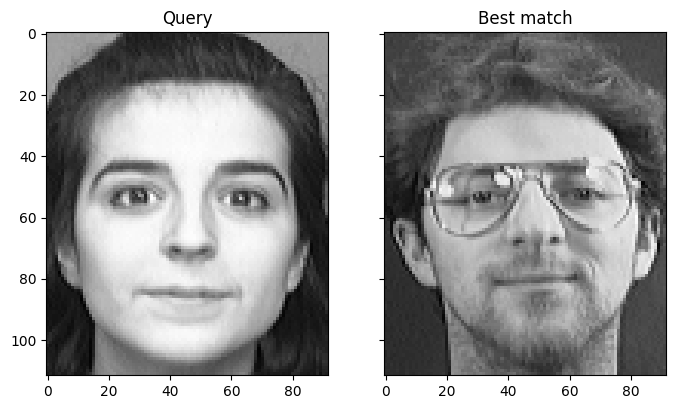

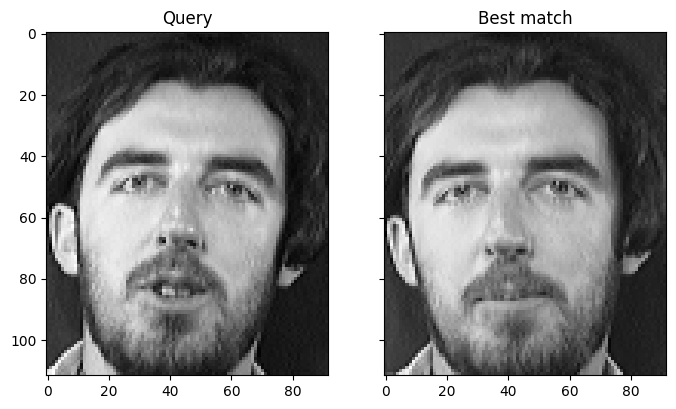

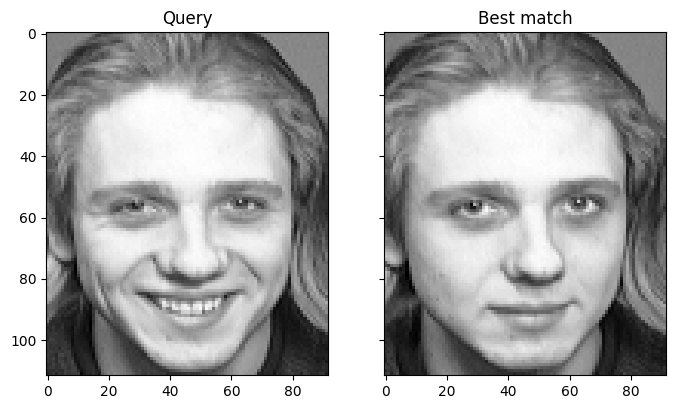

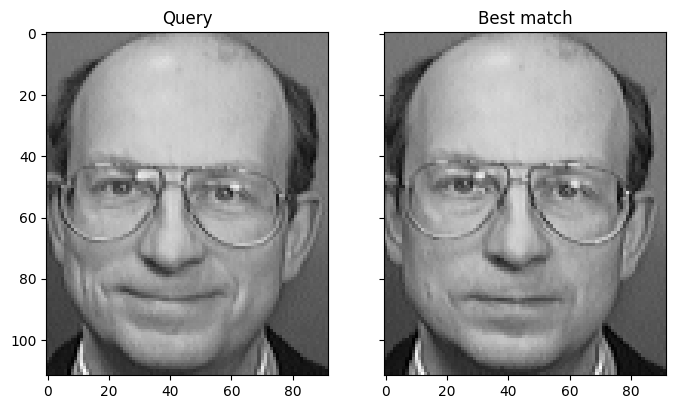

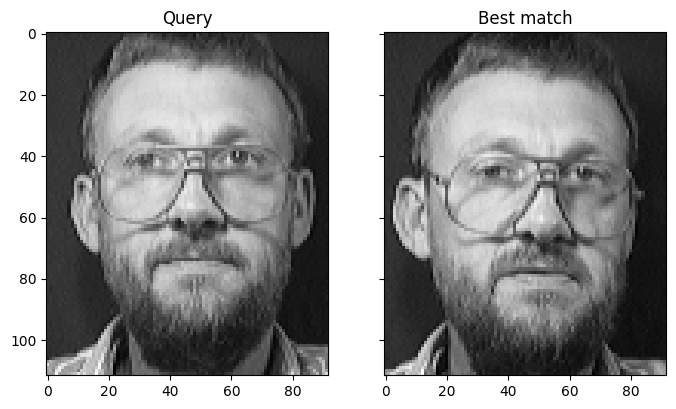

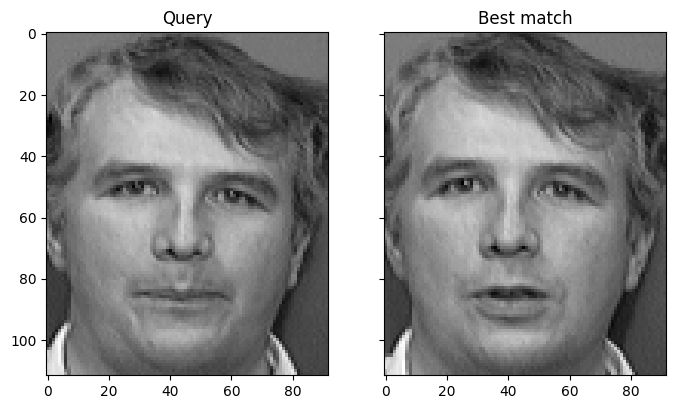

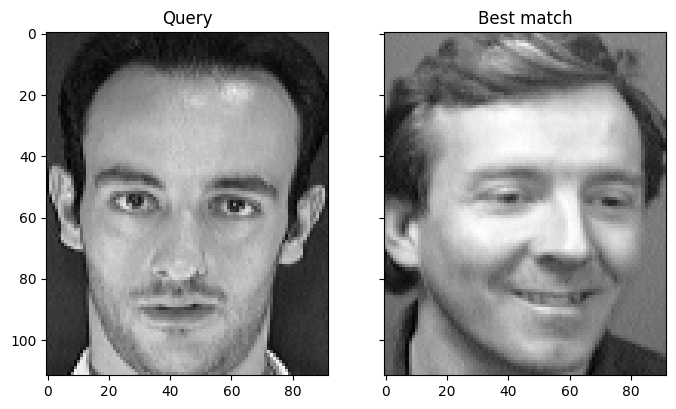

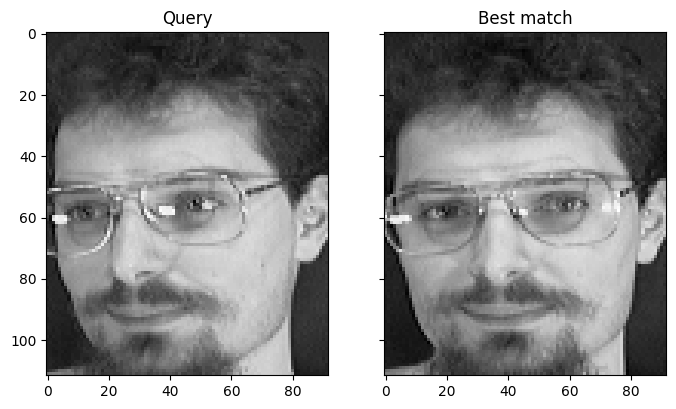

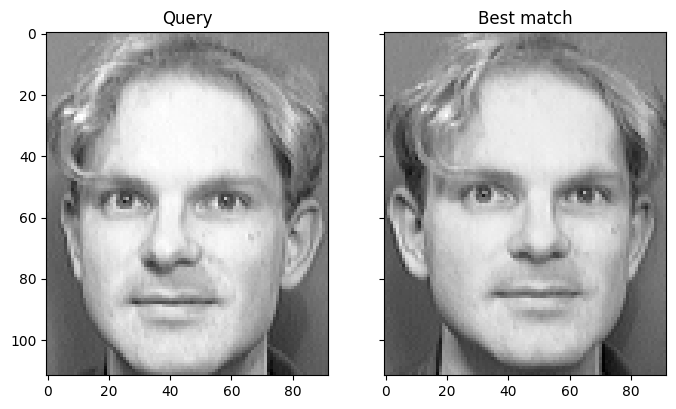

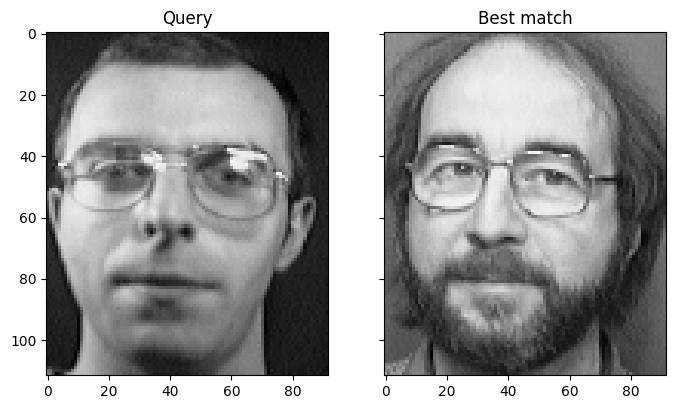

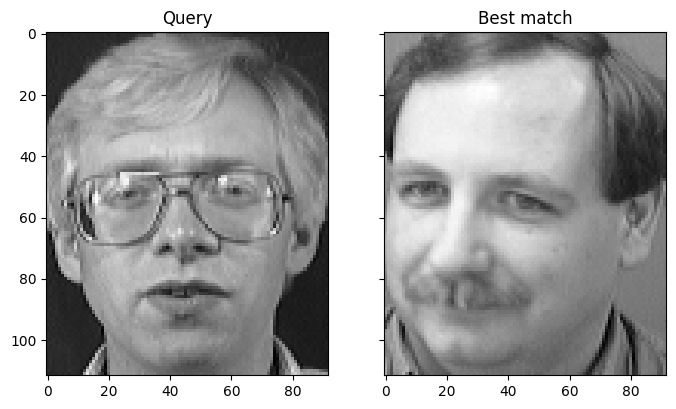

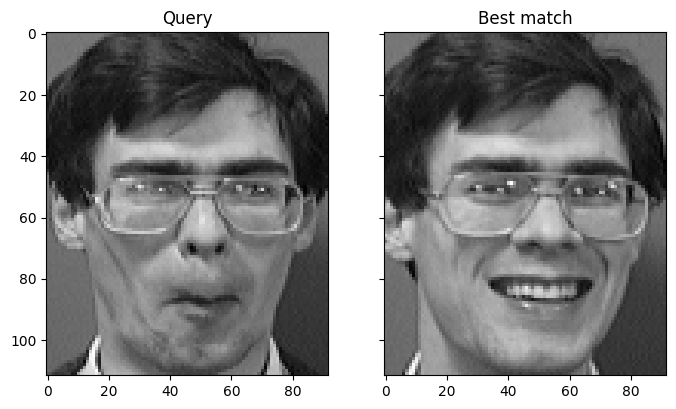

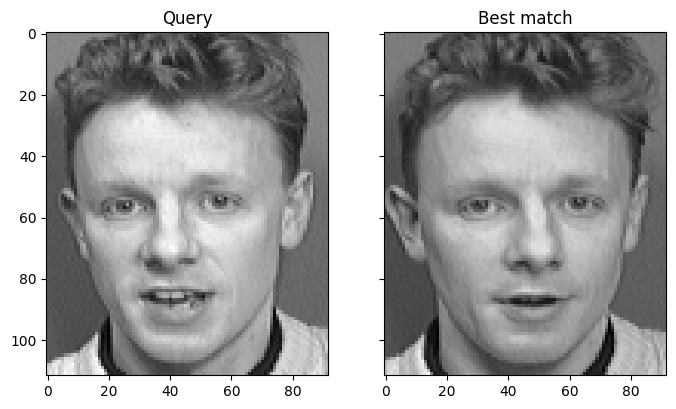

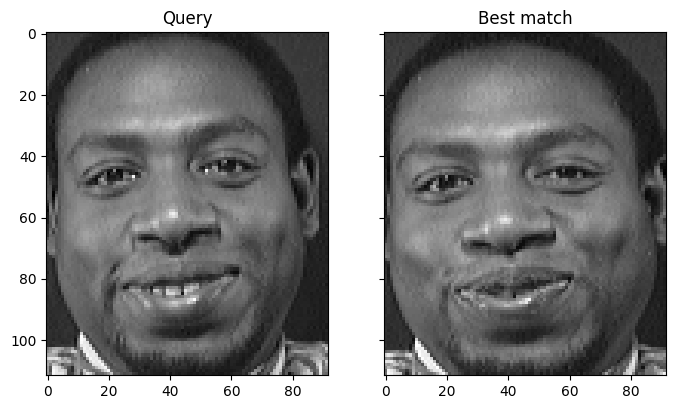

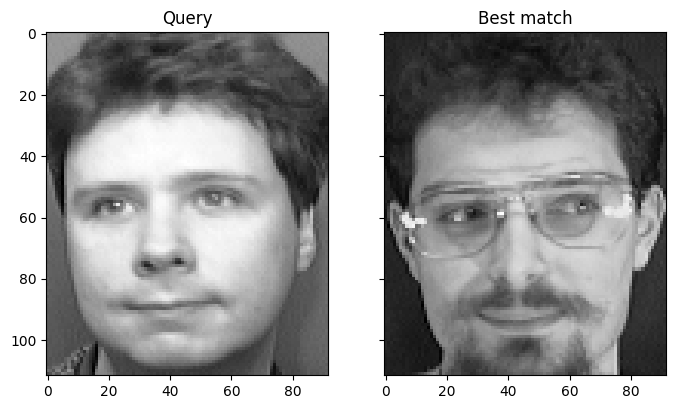

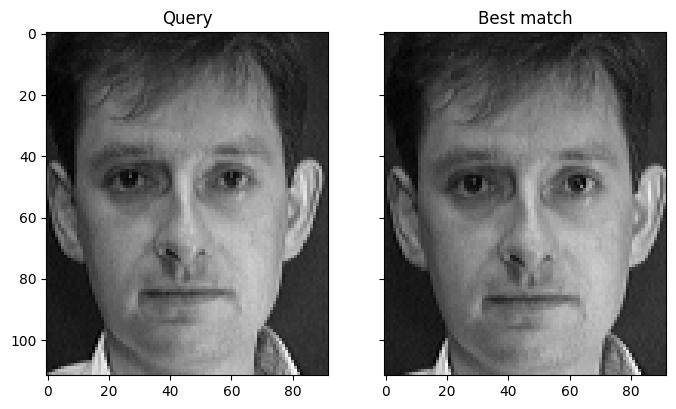

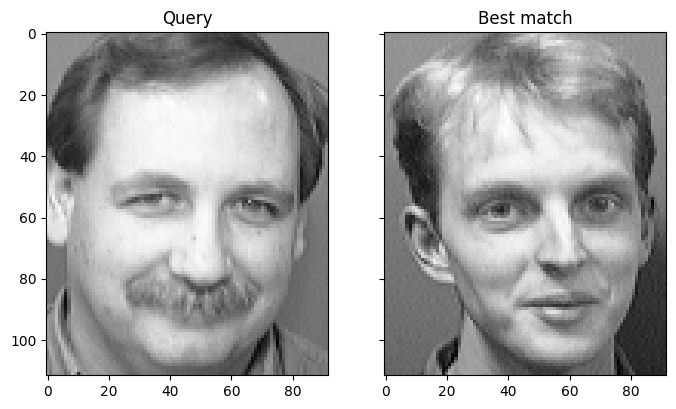

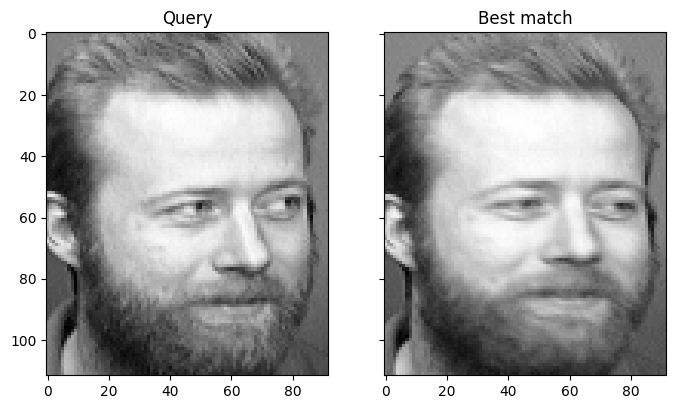

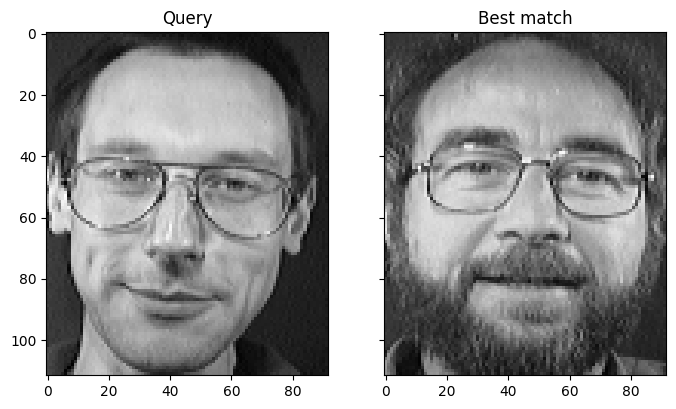

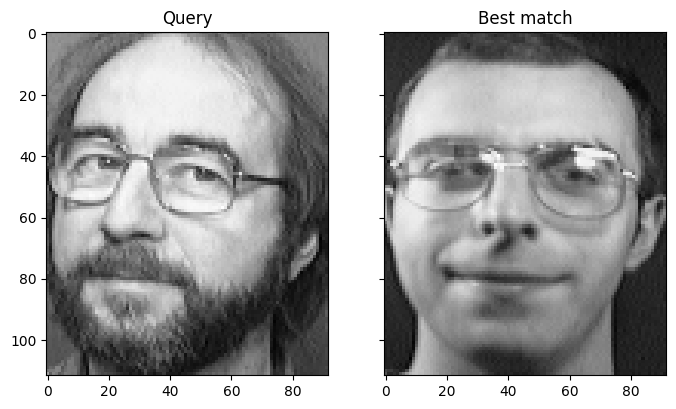

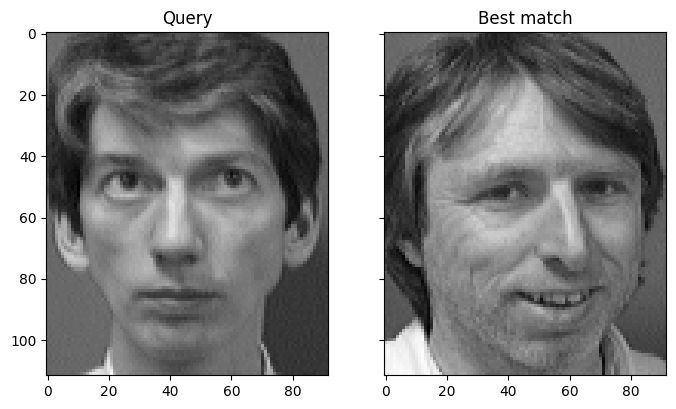

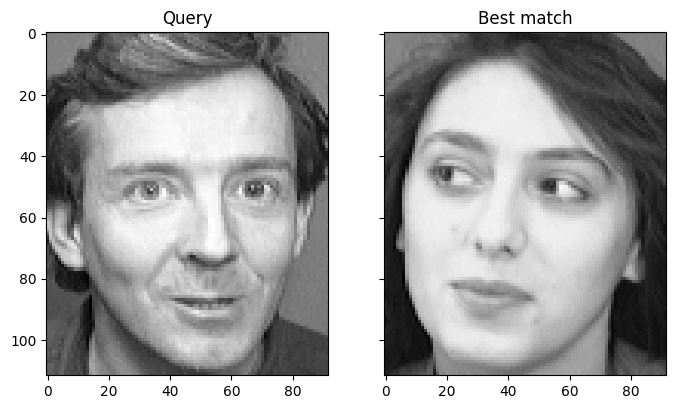

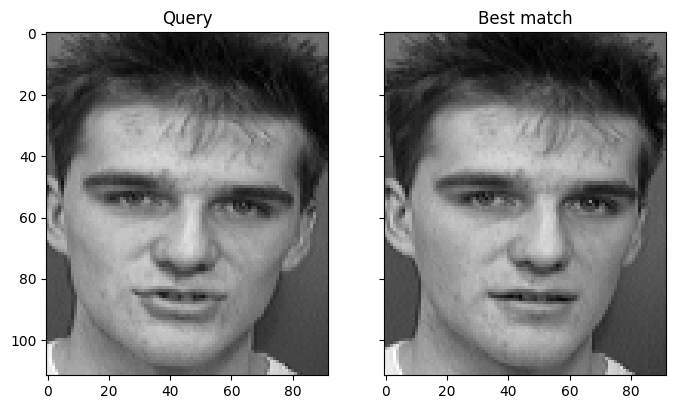

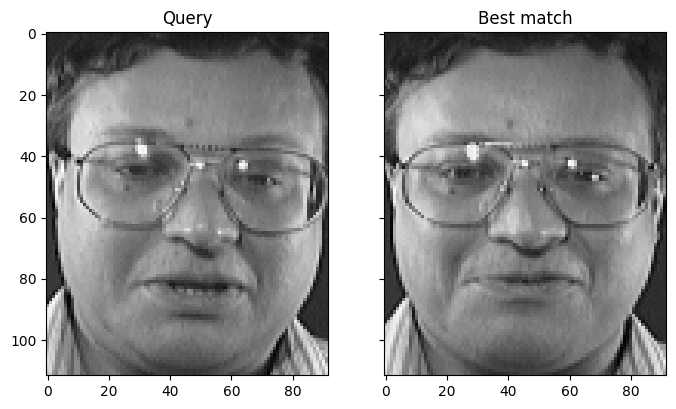

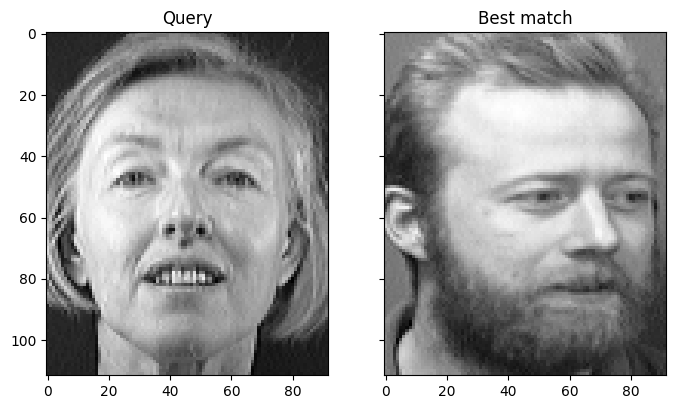

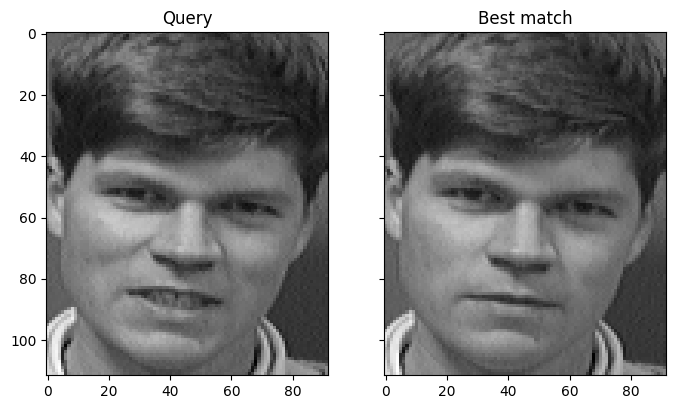

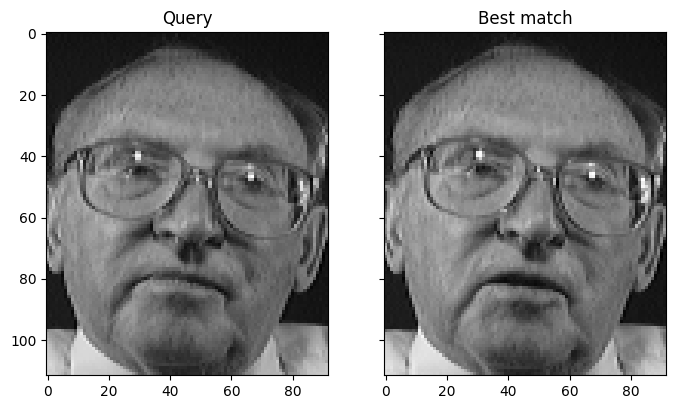

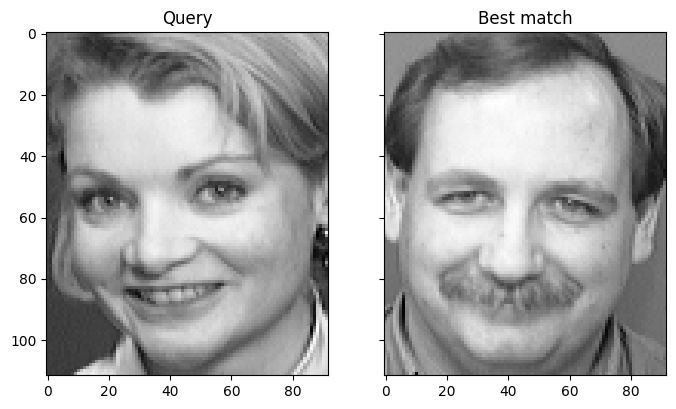

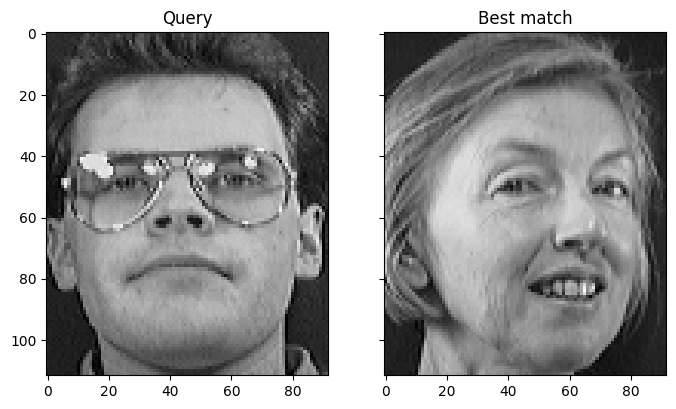

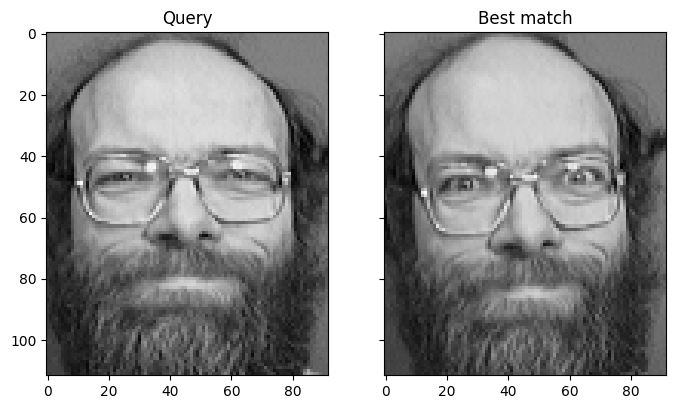

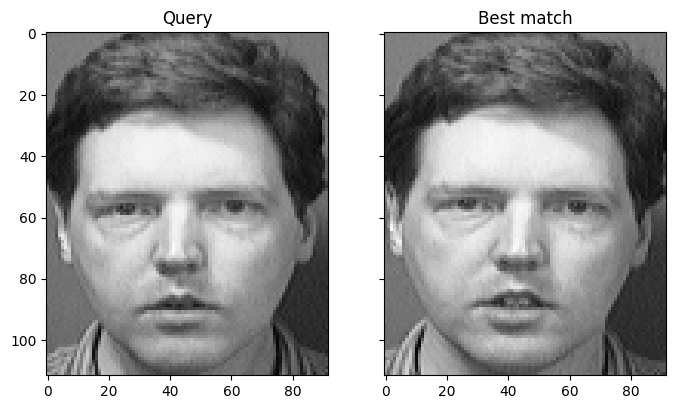

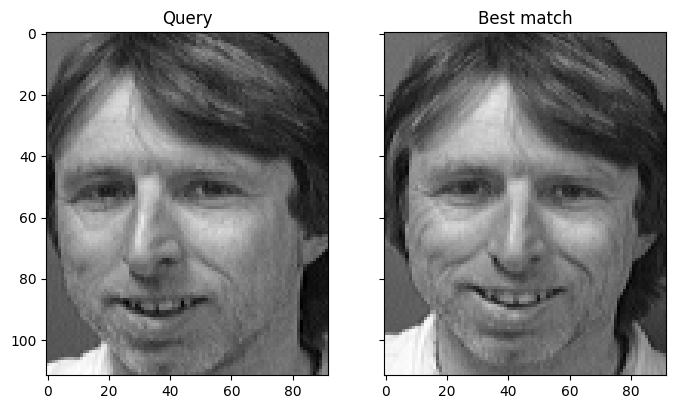

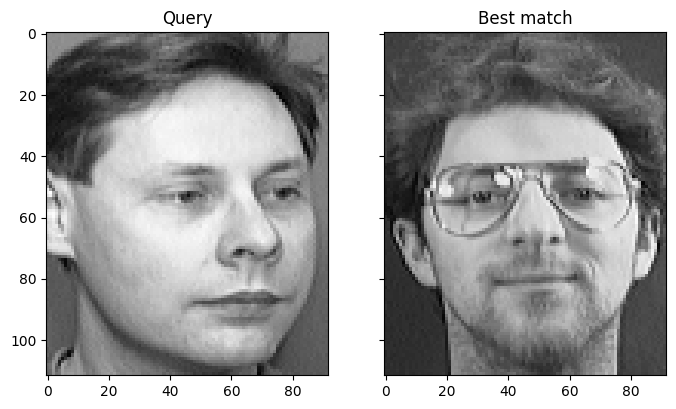

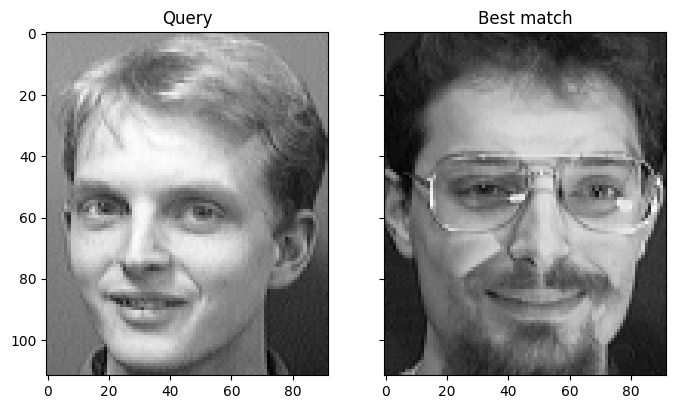

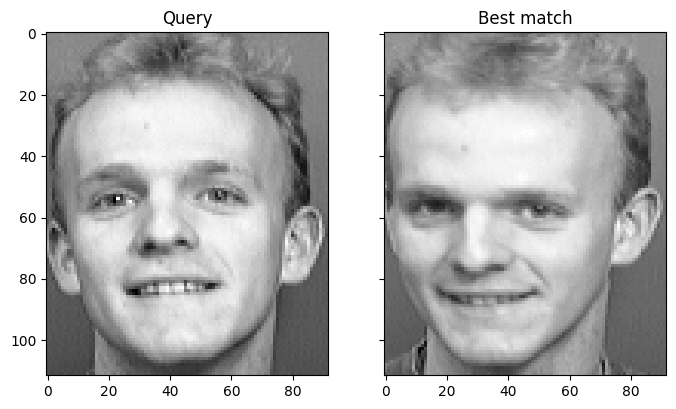

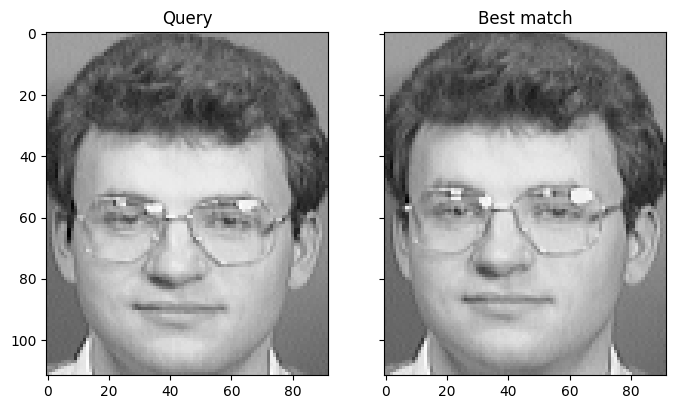

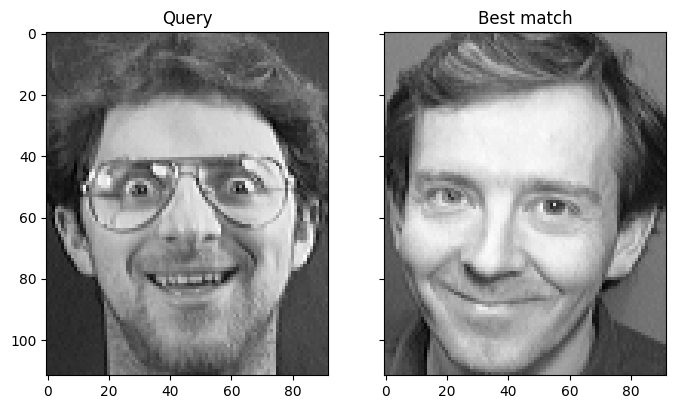

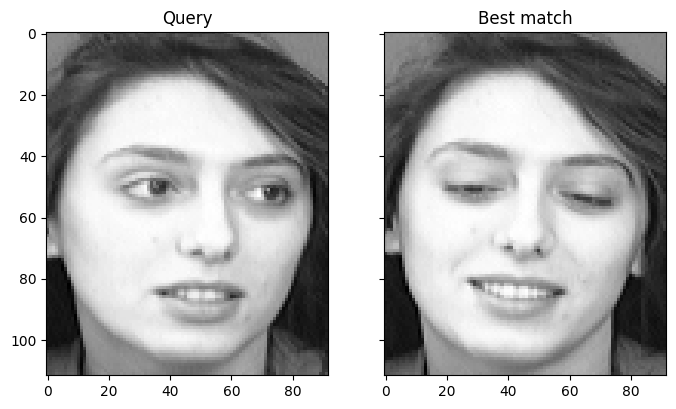

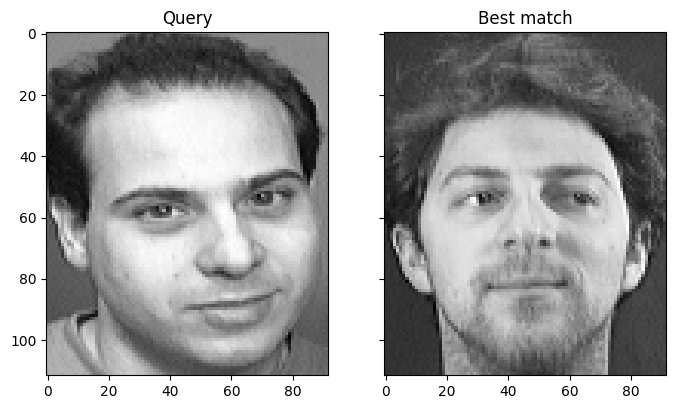

In [463]:
# Visualize
actual_images2=[]
predicted_images2=[]
for i in range(len(test_set_matrix)):
    fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
    actual = test_image_query2[i].reshape(faces_size)
    predicted = train_set_matrix[best_match2[i]].reshape(faces_size)
    actual_images2.append(actual)
    predicted_images2.append(predicted)
    axes[0].imshow(actual, cmap="gray")
    axes[0].set_title("Query")
    axes[1].imshow(predicted, cmap="gray")
    axes[1].set_title("Best match")
    plt.show()




### total explained variance ratio

[1.78645185e-01 1.27166048e-01 6.86586642e-02 5.63132024e-02
 5.02395014e-02 3.42505004e-02 2.46580881e-02 2.38600047e-02
 1.94878554e-02 1.83499789e-02 1.45933679e-02 1.40734235e-02
 1.11285240e-02 1.06363687e-02 9.75494728e-03 8.98435264e-03
 8.64067769e-03 8.59215661e-03 7.49114026e-03 7.13618841e-03
 6.77522610e-03 6.53752325e-03 6.00103097e-03 5.48407561e-03
 5.29846782e-03 5.12180179e-03 4.77652070e-03 4.75156594e-03
 4.58020106e-03 4.52715131e-03 4.37085636e-03 4.08717406e-03
 3.97530414e-03 3.81964020e-03 3.80299409e-03 3.64856602e-03
 3.49406680e-03 3.39017423e-03 3.14822041e-03 3.09247433e-03
 3.06881348e-03 2.97558479e-03 2.90765943e-03 2.79965537e-03
 2.77156782e-03 2.65789068e-03 2.59150969e-03 2.50923228e-03
 2.46721748e-03 2.42505854e-03 2.34968258e-03 2.27223168e-03
 2.23887022e-03 2.11361296e-03 2.10300898e-03 2.08360801e-03
 2.05760603e-03 2.01638923e-03 2.00025373e-03 1.92293233e-03
 1.87487420e-03 1.82742718e-03 1.80012768e-03 1.77577277e-03
 1.69439196e-03 1.675325

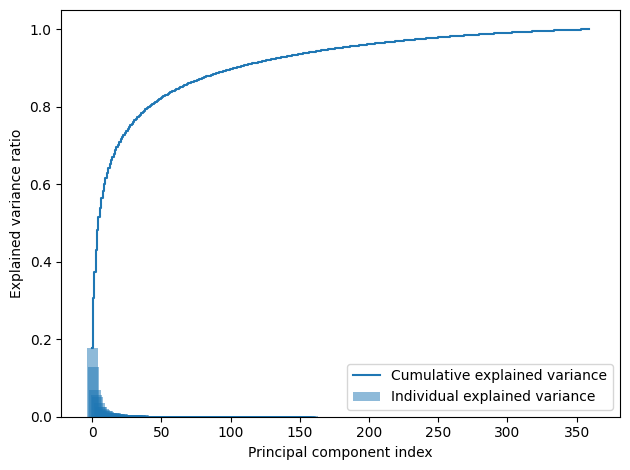

In [466]:
exp_var_ratio=pca.explained_variance_ratio_
print(exp_var_ratio)
cumulative_exp = pca.explained_variance_ratio_.cumsum()
plt.bar(range(0,len(exp_var_ratio)),exp_var_ratio,alpha=0.5,width=8, align='center', label='Individual explained variance')
plt.step(range(0,len(cumulative_exp)),cumulative_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [465]:
confusion_matrix2 = pd.crosstab((np.array(actual_images2)).flatten(),(np.array(predicted_images2)).flatten())
np.diag(confusion_matrix2).sum() / confusion_matrix2.to_numpy().sum()

0.025999611801242235

## Comparing accuracy using 20 eigen faces vs 2
It can be seen that that the accuracy of taking first 20 pricipal components is higher than that of 2. It is also viisble that the ratio increases with increase in principal component index. It is seen that the % of variance is highest for first component and decreases with the increease in them.